# PedSilicoICH: Part 2. Scanners

This notebook also introduces concepts of the `Scanners` Class, and assumes familiarity with the [01_phantoms.ipynb](01_phantoms.ipynb) notebook and continues from it.

In [1]:
%pip install --upgrade pip -q
%pip install matplotlib -q ipywidgets

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


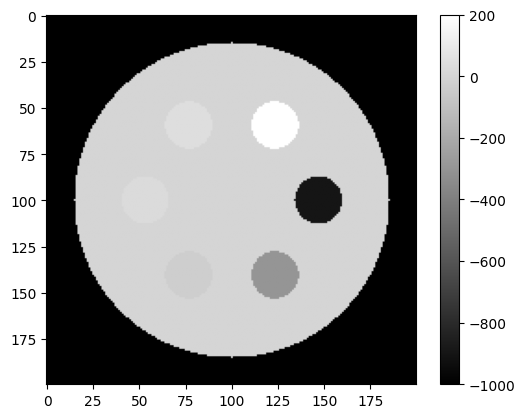

In [2]:
import matplotlib.pyplot as plt

from utils import create_circle_phantom

circles = [-900, -300, -30, 30, 45, 200]
img = create_circle_phantom(image_size=200,
                            large_circle_value=0,
                            bg_value=-1000,
                            small_circle_values=circles,
                            num_small_circles=len(circles))
plt.imshow(img, cmap='gray')
plt.colorbar()

In [3]:
from VITools import get_available_phantoms
get_available_phantoms()

/scratch/brandon.nelson/VITools/.vitools/lib/python3.13/site-packages/monai/utils/module.py:399: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  pkg = __import__(module)  # top level module


{'0.0 yr UNC Head': functools.partial(<class 'insilicoICH.phantoms.head_phantoms.UNC_Head'>, age=0.0, phantom_dir=PosixPath('/projects01/didsr-aiml/brandon.nelson/pedsilicoICH/phantoms/UNC_Head_phantom')),
 '1.0 yr UNC Head': functools.partial(<class 'insilicoICH.phantoms.head_phantoms.UNC_Head'>, age=1.0, phantom_dir=PosixPath('/projects01/didsr-aiml/brandon.nelson/pedsilicoICH/phantoms/UNC_Head_phantom')),
 '2.0 yr UNC Head': functools.partial(<class 'insilicoICH.phantoms.head_phantoms.UNC_Head'>, age=2.0, phantom_dir=PosixPath('/projects01/didsr-aiml/brandon.nelson/pedsilicoICH/phantoms/UNC_Head_phantom')),
 '6.5 yr NIHPD Head': functools.partial(<class 'insilicoICH.phantoms.head_phantoms.NIHPD_Head'>, age=6.5, phantom_dir=PosixPath('/projects01/didsr-aiml/brandon.nelson/pedsilicoICH/phantoms/NIHPD_Head_Phantom')),
 '9.0 yr NIHPD Head': functools.partial(<class 'insilicoICH.phantoms.head_phantoms.NIHPD_Head'>, age=9.0, phantom_dir=PosixPath('/projects01/didsr-aiml/brandon.nelson/ped

In [4]:
from VITools import Phantom, Scanner
phantom = Phantom(img[None], spacings=(200, 1, 1))
phantom


        Phantom Class: Phantom
        Age (years): 0
        Shape (voxels): (1, 200, 200)
        Size (mm): (200.0, 200.0, 200.0)
        

In [5]:
scanner = Scanner(phantom, 'Siemens_DefinitionFlash')
scanner

Initializing Scanner object...
----------
* Calculating volume fraction maps for 4 materials and 1 slices...
* Writing volume fraction files for 4 materials and 1 slices, plus HU data...
* Writing /tmp/tmpan6sq00j/default/phantoms/0/0_ncat_adipose_200x200x1.raw...
* Writing /tmp/tmpan6sq00j/default/phantoms/0/0_ncat_water_200x200x1.raw...
* Writing /tmp/tmpan6sq00j/default/phantoms/0/0_ncat_brain_200x200x1.raw...
* Writing /tmp/tmpan6sq00j/default/phantoms/0/0_ncat_skull_200x200x1.raw...
* Writing /tmp/tmpan6sq00j/default/phantoms/0/0_HU_data_200x200x1.raw...
* Writing /tmp/tmpan6sq00j/default/phantoms/0/0.json...
Scanner Ready



        Scanner default_series
        Scanner: Siemens_DefinitionFlash
        Simulation Platform: CATSIM
        

In [6]:
class PhotonCountingScanner(Scanner):
    def __init__(self, *args, scanner_model='Scanner_PCCT', **kwargs):
        super().__init__(*args, scanner_model=scanner_model, **kwargs)

    def run_scan(self, *args, sum_bins=False, **kwargs):
        self.xcist.cfg.scanner.detectorSumBins = sum_bins
        if not self.xcist.cfg.scanner.detectorSumBins:
            self.xcist.do_prep = 0
        super().run_scan(*args, **kwargs)

    def run_recon(self, *args, threshold=70, enoise_threshold=True, **kwargs):
        '''
        threshold: kV threshold to split energy bins into upper and lower energy
        See Scanner.run_recon for *args, and **kwargs definitions.

        Returns self.recon as [bins, slices, rows, cols] with low energy, high energy
        '''
        neglog_lower, neglog_upper = self.threshold_sum(threshold, enoise_threshold)
        # first lower energy bin
        original_projections = self._projections
        original_name = self.xcist.resultsName
        if len(self._projections) > 1:
            for i in range(len(self._projections)):
                self._projections[i] = original_projections[i] + f'_thresh_{threshold}kV_lower'
                xc.rawwrite(self._projections[i]+'.prep', neglog_lower)
        else:
            self.xcist.resultsName = original_name + f'_thresh_{threshold}kV_lower'
            self.xcist.cfg.resultsName = self.xcist.resultsName
            self._projections = [o + f'_thresh_{threshold}kV_lower' for o in original_projections]
            xc.rawwrite(self.xcist.resultsName+'.prep', neglog_lower)
        print(f'reconstructing: {self.xcist.resultsName}')
        super().run_recon(*args, **kwargs)
        proj_lower = self.projections.copy()
        recon_lower = self.recon.copy()
        self.xcist.resultsName = original_name
        self.xcist.cfg.resultsName = self.xcist.resultsName
        self._projections = original_projections
        
        # now upper
        original_projections = self._projections
        original_name = self.xcist.resultsName
        if len(self._projections) > 1:
            for i in range(len(self._projections)):
                self._projections[i] = original_projections[i] + f'_thresh_{threshold}kV_upper'
                xc.rawwrite(self._projections[i]+'.prep', neglog_upper)
        else:
            self.xcist.resultsName = original_name + f'_thresh_{threshold}kV_upper'
            self.xcist.cfg.resultsName = self.xcist.resultsName
            self._projections = [o + f'_thresh_{threshold}kV_upper' for o in original_projections]
            xc.rawwrite(self.xcist.resultsName+'.prep', neglog_upper)
        print(f'reconstructing: {self.xcist.resultsName}')
        super().run_recon(*args, **kwargs)
        proj_upper = self.projections.copy()
        recon_upper = self.recon.copy()       
        self.xcist.resultsName = original_name
        self.xcist.cfg.resultsName = self.xcist.resultsName
        self._projections = original_projections

        self.projections = np.stack([proj_lower, proj_upper])
        self.recon = np.stack([recon_lower, recon_upper])

    def threshold_sum(self, thresh, enoise_threshold):
        ct = self.xcist
        nBin = len(ct.scanner.detectorBinThreshold)-1
        scan = xc.rawread(ct.resultsName + '.scan', [ct.protocol.viewCount,
                                                     ct.scanner.detectorRowCount,
                                                     ct.scanner.detectorColCount, nBin], 'float')
        offset = xc.rawread(ct.resultsName + '.offset', [ct.scanner.detectorRowCount,
                                                         ct.scanner.detectorColCount, nBin], 'float')
        air = xc.rawread(ct.resultsName + '.air', [ct.scanner.detectorRowCount,
                                                   ct.scanner.detectorColCount, nBin], 'float')

        bins = np.array(ct.scanner.detectorBinThreshold)[:-1]

        if enoise_threshold:
            scan_lower = scan[:, :, :, (25 < bins) & (bins < thresh)]
        else:
            scan_lower = scan[:, :, :, bins < thresh]
        scan_upper = scan[:, :, :, bins >= thresh]

        if enoise_threshold:
            air_lower = air[:, :, (25 < bins) & (bins < thresh)]
        else:
            air_lower = air[:, :, bins < thresh]
        air_upper = air[:, :, bins >= thresh]

        if enoise_threshold:
            offset_lower = offset[:, :, (25 < bins) & (bins < thresh)]
        else:
            offset_lower = offset[:, :, bins < thresh]
        offset_upper = offset[:, :, bins >= thresh]
        #
        scan_lower_sum = scan_lower.sum(axis=-1)
        scan_upper_sum = scan_upper.sum(axis=-1)

        air_lower_sum = air_lower.sum(axis=-1)
        air_upper_sum = air_upper.sum(axis=-1)

        offset_lower_sum = offset_lower.sum(axis=-1)
        offset_upper_sum = offset_upper.sum(axis=-1)

        neglog_lower = -np.log((scan_lower_sum - offset_lower_sum)/
                               (air_lower_sum - offset_lower_sum))
        neglog_upper = -np.log((scan_upper_sum - offset_upper_sum)/
                               (air_upper_sum - offset_upper_sum))
        return neglog_lower, neglog_upper

## Use `scanner.scout_view()` to determine scan range

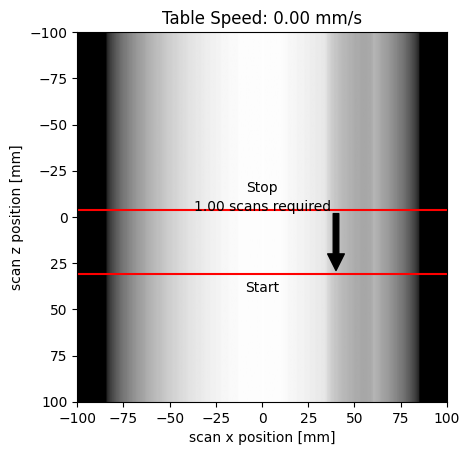

In [7]:
scans = 1  # edit me

center = 0
scan_width = 7
width = scan_width*scans
startZ = center - width / 2
endZ = center + width / 2

scanner.scout_view(startZ, endZ)

In [8]:
acquisition_technique = dict(
    mA=200,
    kVp=120,
    views=100,
    startZ=startZ,
    endZ=endZ
)
scanner.run_scan(**acquisition_technique)

scan: 1/1
Airscan
Offset scan
Phantom scan


  0%|          | 0/100 [00:00<?, ?it/s]

in C> Preparing to allocate memory for material volume data...
in C> Allocated memory for image volume for material  1
in C> Copying data for material  1 into C memory...in C>  done.
in C> Allocated memory for image volume for material  2
in C> Copying data for material  2 into C memory...in C>  done.
in C> Allocated memory for image volume for material  3
in C> Copying data for material  3 into C memory...in C>  done.
in C> Allocated memory for image volume for material  4
in C> Copying data for material  4 into C memory...in C>  done.
in C> Allocated a total of      0 MB.


100%|██████████| 100/100 [01:55<00:00,  1.15s/it]


Prep view
Applying LSC...done.

Applying Beam Hardening Correction (ACCURATE BHC)...Airscan
done.

Simulation is done.



        Scanner default_series
        Scanner: Siemens_DefinitionFlash
        Simulation Platform: CATSIM
        

In [9]:
recon_technique = dict(
    kernel='standard',
    fov=250,
    slice_thickness=1,
    slice_increment=None
)
scanner.run_recon(**recon_technique)

fov size: 250
* Loading the projection data...
* Pre-weighting the filter...
* Applying the filter...
* Running the reconstruction...
* Converting projection data from a numpy array to a C array...
* Allocating a C array for the recon results...
* In C...
* Converting the recon results from a C array to a numpy array...
* Scaling recon data...



        Scanner default_series
        Scanner: Siemens_DefinitionFlash
        Simulation Platform: CATSIM
        
Recon: (27, 512, 512) 25.0 cm fov
Projections: (100, 64, 900)

## View the result

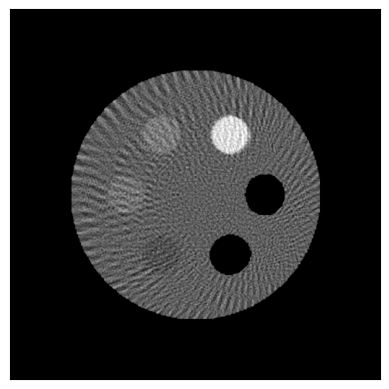

In [10]:
from utils import ctshow
ctshow(scanner.recon)

In [11]:
scanner.write_to_dicom('CTP404/CTP404.dcm')

/scratch/brandon.nelson/VITools/.vitools/lib/python3.13/site-packages/pydicom/valuerep.py:440: UserWarning: Invalid value for VR UI: '1.3.6.1.4.1.5962.1.3.1.1.20040119072730.00'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warn_and_log(msg)
/scratch/brandon.nelson/VITools/.vitools/lib/python3.13/site-packages/pydicom/valuerep.py:440: UserWarning: Invalid value for VR UI: '1.3.6.1.4.1.5962.1.1.1.1.1.20040119072730.000'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warn_and_log(msg)
/scratch/brandon.nelson/VITools/.vitools/lib/python3.13/site-packages/pydicom/valuerep.py:440: UserWarning: Invalid value for VR UI: '1.3.6.1.4.1.5962.1.1.1.1.1.20040119072730.001'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warn_and_log(msg)
/scratch/brandon.ne

[PosixPath('CTP404/CTP404_000.dcm'),
 PosixPath('CTP404/CTP404_001.dcm'),
 PosixPath('CTP404/CTP404_002.dcm'),
 PosixPath('CTP404/CTP404_003.dcm'),
 PosixPath('CTP404/CTP404_004.dcm'),
 PosixPath('CTP404/CTP404_005.dcm'),
 PosixPath('CTP404/CTP404_006.dcm'),
 PosixPath('CTP404/CTP404_007.dcm'),
 PosixPath('CTP404/CTP404_008.dcm'),
 PosixPath('CTP404/CTP404_009.dcm'),
 PosixPath('CTP404/CTP404_010.dcm'),
 PosixPath('CTP404/CTP404_011.dcm'),
 PosixPath('CTP404/CTP404_012.dcm'),
 PosixPath('CTP404/CTP404_013.dcm'),
 PosixPath('CTP404/CTP404_014.dcm'),
 PosixPath('CTP404/CTP404_015.dcm'),
 PosixPath('CTP404/CTP404_016.dcm'),
 PosixPath('CTP404/CTP404_017.dcm'),
 PosixPath('CTP404/CTP404_018.dcm'),
 PosixPath('CTP404/CTP404_019.dcm'),
 PosixPath('CTP404/CTP404_020.dcm'),
 PosixPath('CTP404/CTP404_021.dcm'),
 PosixPath('CTP404/CTP404_022.dcm'),
 PosixPath('CTP404/CTP404_023.dcm'),
 PosixPath('CTP404/CTP404_024.dcm'),
 PosixPath('CTP404/CTP404_025.dcm'),
 PosixPath('CTP404/CTP404_026.dcm')]

In [ ]:
mAs = [20, 80, 320]
mA_recons = []
for mA in mAs:
    scanner.run_scan(mA=mA, startZ=startZ, endZ=endZ, views=500)
    scanner.run_recon(slice_thickness=1, kernel='soft')
    mA_recons.append(scanner.recon)

scan: 1/1
Airscan
Offset scan
Phantom scan


  0%|          | 0/500 [00:00<?, ?it/s]

in C> Preparing to allocate memory for material volume data...
in C> Allocated memory for image volume for material  1
in C> Copying data for material  1 into C memory...in C>  done.
in C> Allocated memory for image volume for material  2
in C> Copying data for material  2 into C memory...in C>  done.
in C> Allocated memory for image volume for material  3
in C> Copying data for material  3 into C memory...in C>  done.
in C> Allocated memory for image volume for material  4
in C> Copying data for material  4 into C memory...in C>  done.
in C> Allocated a total of      0 MB.


100%|██████████| 500/500 [09:11<00:00,  1.10s/it]


Prep view
Applying LSC...done.

Applying Beam Hardening Correction (ACCURATE BHC)...Airscan
done.

Simulation is done.
fov size: 250
* Loading the projection data...
* Pre-weighting the filter...
* Applying the filter...


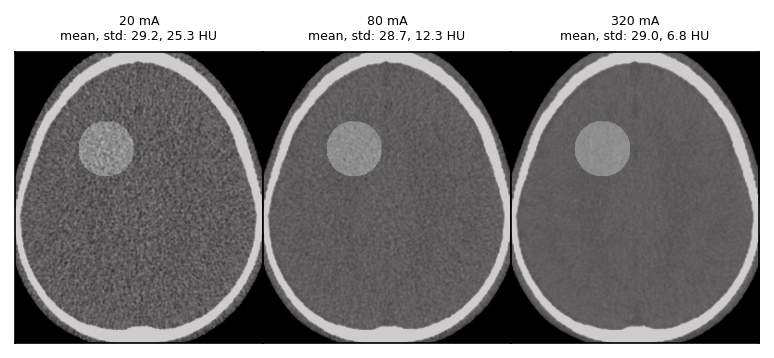

In [ ]:
from utils import ctshow, center_crop, center_crop_like, circle_select
import matplotlib.pyplot as plt

roi_params = dict(
    xy = (200, 220),
    r=30
)

show_roi = True

f, axs = plt.subplots(1, len(mA_recons), gridspec_kw=dict(wspace=0, hspace=0), dpi=150)
for ax, recon, mA in zip(axs.flatten(), mA_recons, mAs):
    ctshow(center_crop(recon[0]), fig=f, ax=ax)
    roi = circle_select(recon[0], **roi_params)
    if show_roi:
        ax.imshow(center_crop_like(roi, recon[0]), cmap='hot', alpha=0.2)
    mean = recon[0][roi].mean()
    std = recon[0][roi].std()
    ax.set_title(f'{mA} mA\nmean, std: {mean:2.1f}, {std:2.1f} HU', fontsize=6)

In [ ]:
kVps = [80, 100, 120, 140]
kVp_recons = []
for kVp in kVps:
    mA = 200 * (120 / kVp)**2 # accounts for the fact that tube output scales by kVp^2
    print(f'{kVp} kVp, {mA} mA')
    scanner.run_scan(kVp=kVp, mA=mA, startZ=startZ, endZ=endZ, views=500)
    scanner.run_recon(slice_thickness=1, kernel='soft')
    kVp_recons.append(scanner.recon)

80 kVp, 450.0 mA
scan: 1/1
Airscan
Offset scan
Phantom scan


  0%|          | 0/500 [00:00<?, ?it/s]

in C> Preparing to allocate memory for material volume data...
in C> Allocated memory for image volume for material  1
in C> Copying data for material  1 into C memory...in C>  done.
in C> Allocated memory for image volume for material  2
in C> Copying data for material  2 into C memory...in C>  done.
in C> Allocated memory for image volume for material  3
in C> Copying data for material  3 into C memory...in C>  done.
in C> Allocated memory for image volume for material  4
in C> Copying data for material  4 into C memory...in C>  done.
in C> Allocated a total of    132 MB.


  7%|▋         | 37/500 [00:52<10:12,  1.32s/it]

 79%|███████▉  | 395/500 [09:22<03:00,  1.72s/it]

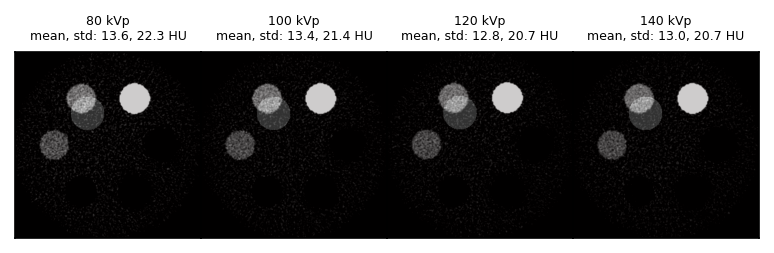

In [ ]:
show_roi = True

f, axs = plt.subplots(1, len(kVp_recons), gridspec_kw=dict(wspace=0, hspace=0), dpi=150)
for ax, recon, kVp in zip(axs.flatten(), kVp_recons, kVps):
    ctshow(center_crop(recon[0]), 'brain', fig=f, ax=ax)
    roi = circle_select(recon[0], **roi_params)
    if show_roi:
        ax.imshow(center_crop_like(roi, recon[0]), cmap='hot', alpha=0.2)
    mean = recon[0][roi].mean()
    std = recon[0][roi].std()
    ax.set_title(f'{kVp} kVp\nmean, std: {mean:2.1f}, {std:2.1f} HU', fontsize=6)

In [ ]:
scanner.run_scan(kVp=120, mA=200, startZ=startZ, endZ=endZ, views=500)

scan: 1/1
Airscan


Offset scan
Phantom scan


  0%|          | 0/500 [00:00<?, ?it/s]

in C> Preparing to allocate memory for material volume data...
in C> Allocated memory for image volume for material  1
in C> Copying data for material  1 into C memory...in C>  done.
in C> Allocated memory for image volume for material  2
in C> Copying data for material  2 into C memory...in C>  done.
in C> Allocated memory for image volume for material  3
in C> Copying data for material  3 into C memory...in C>  done.
in C> Allocated memory for image volume for material  4
in C> Copying data for material  4 into C memory...in C>  done.
in C> Allocated a total of      0 MB.


100%|██████████| 500/500 [02:11<00:00,  3.81it/s]


Prep view
Applying LSC...done.

Applying Beam Hardening Correction (ACCURATE BHC)...Airscan
done.

Simulation is done.



        <class 'VITools.scanner.Scanner'> default_series
        Scanner: Scanner_Default
        Simulation Platform: CATSIM
        
Recon: (7, 512, 512) 25.0 cm fov
Projections: (500, 16, 900)

In [ ]:
kernels = ['bone', 'standard', 'soft']

recons = []
for kernel in kernels:
    scanner.run_recon(slice_thickness=1, kernel=kernel)
    recons.append(scanner.recon)

fov size: 250
* Loading the projection data...
* Pre-weighting the filter...
* Applying the filter...


* Running the reconstruction...
* Converting projection data from a numpy array to a C array...
* Allocating a C array for the recon results...
* In C...
* Converting the recon results from a C array to a numpy array...
* Scaling recon data...
fov size: 250
* Loading the projection data...
* Pre-weighting the filter...
* Applying the filter...
* Running the reconstruction...
* Converting projection data from a numpy array to a C array...
* Allocating a C array for the recon results...
* In C...
* Converting the recon results from a C array to a numpy array...
* Scaling recon data...
fov size: 250
* Loading the projection data...
* Pre-weighting the filter...
* Applying the filter...
* Running the reconstruction...
* Converting projection data from a numpy array to a C array...
* Allocating a C array for the recon results...
* In C...
* Converting the recon results from a C array to a numpy array...
* Scaling recon data...


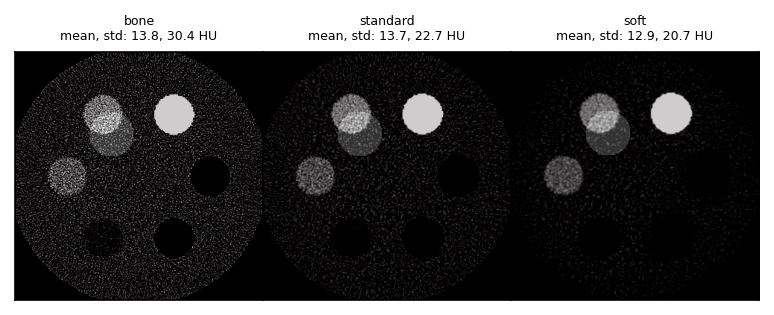

In [ ]:
show_roi = True

f, axs = plt.subplots(1, len(recons), gridspec_kw=dict(wspace=0, hspace=0), dpi=150)
for ax, recon, kernel in zip(axs.flatten(), recons, kernels):
    ctshow(center_crop(recon[0]), 'brain', fig=f, ax=ax)
    roi = circle_select(recon[0], **roi_params)
    if show_roi:
        ax.imshow(center_crop_like(roi, recon[0]), cmap='hot', alpha=0.2)
    mean = recon[0][roi].mean()
    std = recon[0][roi].std()
    ax.set_title(f'{kernel}\nmean, std: {mean:2.1f}, {std:2.1f} HU', fontsize=6)

In [ ]:
from VITools import Study

In [ ]:
study = Study(scanner)
study


Input metadata:

Empty DataFrame
Columns: []
Index: []

Results:

Empty DataFrame
Columns: []
Index: []

In [ ]:
study.run_study?

Signature: study.run_study(patientid: int = 0)
Docstring:
Runs a single simulation study for a specific patient/case ID.

This method orchestrates the simulation for one entry in the
`self.metadata` DataFrame. It involves:
1. Initializing the specified phantom.
2. Setting up the virtual scanner.
3. Determining the scan range (z-axis coverage).
4. Running the scan (projection data generation).
5. Running the reconstruction.
6. Writing the reconstructed images to DICOM files.
7. Saving metadata about the scan.
8. Optionally, removing raw projection data.

Args:
    patientid (int, optional):
        The index of the scan configuration in `self.metadata` to run.
        Defaults to 0 (the first scan).

Returns:
    Study: The Study instance itself.

Raises:
    KeyError: If the phantom specified in the metadata is not found.
    IndexError: If `patientid` is out of bounds for `self.metadata`.
File:      /scratch/brandon.nelson/VITools/.vitools/lib/python3.13/site-packages/VITools/study.py

In [ ]:
study.run_study(zspan=(startZ, endZ))

TypeError: Study.run_study() got an unexpected keyword argument 'zspan'

In [ ]:
study.metadata

,Name,Age,kVp,mA,Views,ReconKernel,SliceThickness(mm),LesionAttenuation(HU),LesionVolume(mL),Subtype,MassEffect,CenterX,CenterY,CenterZ,FOV(mm),ImageFilePath,MaskFilePath
0,default,0,120,200,1000,standard,1,None,[0.0],None,None,None,None,None,250,/tmp/tmpikpnmpou/default/dicoms/default_000.dcm,None
1,default,0,120,200,1000,standard,1,None,[0.0],None,None,None,None,None,250,/tmp/tmpikpnmpou/default/dicoms/default_001.dcm,None
2,default,0,120,200,1000,standard,1,None,[0.0],None,None,None,None,None,250,/tmp/tmpikpnmpou/default/dicoms/default_002.dcm,None
3,default,0,120,200,1000,standard,1,None,[0.0],None,None,None,None,None,250,/tmp/tmpikpnmpou/default/dicoms/default_003.dcm,None
4,default,0,120,200,1000,standard,1,None,[0.0],None,None,None,None,None,250,/tmp/tmpikpnmpou/default/dicoms/default_004.dcm,None
5,default,0,120,200,1000,standard,1,None,[0.0],None,None,None,None,None,250,/tmp/tmpikpnmpou/default/dicoms/default_005.dcm,None
6,default,0,120,200,1000,standard,1,None,[0.0],None,None,None,None,None,250,/tmp/tmpikpnmpou/default/dicoms/default_006.dcm,None
